In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('data.csv').drop('Unnamed: 0', axis=1)
labels = pd.read_csv('labels.csv').drop('Unnamed: 0', axis=1).to_numpy()

# Imputing, Feature Selection & Label Encoding

In [3]:
data.info()

print()
print('Any missing values?', np.any(np.any(data.isna(), axis=0)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Columns: 20531 entries, gene_0 to gene_20530
dtypes: float64(20531)
memory usage: 125.5 MB

Any missing values? False


We have high-dimensional data. However, as we can see below, 267 of the features contain only a single value which does not really help with classification. We will get rid of these features.

In [4]:
num_unique_vals = data.nunique()
print(num_unique_vals[num_unique_vals == 1])

data = data.drop(num_unique_vals[num_unique_vals == 1].index, axis=1)

gene_5        1
gene_23       1
gene_4370     1
gene_4808     1
gene_4809     1
             ..
gene_18915    1
gene_19450    1
gene_19451    1
gene_19452    1
gene_19671    1
Length: 267, dtype: int64


In [5]:
from sklearn.preprocessing import LabelEncoder

print(np.unique(labels))

encoder = LabelEncoder()
labels = encoder.fit_transform(labels.ravel())

['BRCA' 'COAD' 'KIRC' 'LUAD' 'PRAD']


We noticed that the distribution of samples into classes in our dataset is not entirely balanced. The difference between the first and the second class is more than 200 samples. We will leave it like that for now, but we will come back and take care of this problem.

In [6]:
print('Classes and their counts')
print(*np.unique(labels, return_counts=True))

Classes and their counts
[0 1 2 3 4] [300  78 146 141 136]


In [7]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(
    data.to_numpy(), labels, test_size=0.2, stratify=labels, random_state=10
)

# Classification Algorithms

In [8]:
from sklearn.base import BaseEstimator
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


def evaluate_classifier(
    classifier: BaseEstimator,
    train_data: np.ndarray, train_labels: np.ndarray,
    test_data: np.ndarray, test_labels: np.ndarray,
    confusion: bool = False
) -> float:
    classifier.fit(train_data, train_labels)
    
    preds = classifier.predict(test_data)
    acc = accuracy_score(test_labels, preds)
    
    if confusion:
        ConfusionMatrixDisplay.from_predictions(test_labels, preds)
        plt.show()
    
    return acc

We decided to use Logistic Regression, SVM and Decision Trees for our experiments. Our baseline scores with no scaling and no data balancing are 0.993789 for LogReg, 0.992789 for SVM and 0.962733 for DT. Let's try to improve these.

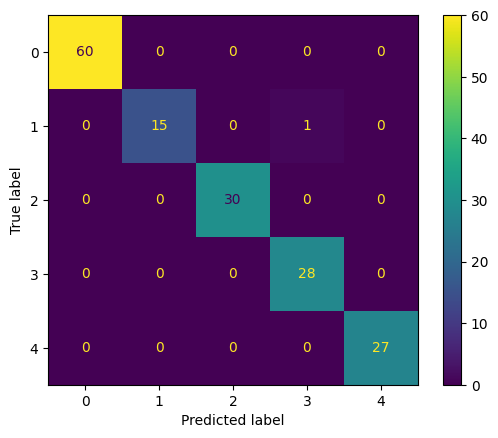

0.9937888198757764

In [9]:
logreg = SGDClassifier('log_loss', n_jobs=-1, random_state=10)
baseline_logreg_acc = evaluate_classifier(logreg, train_data, train_labels, test_data, test_labels, True)
baseline_logreg_acc

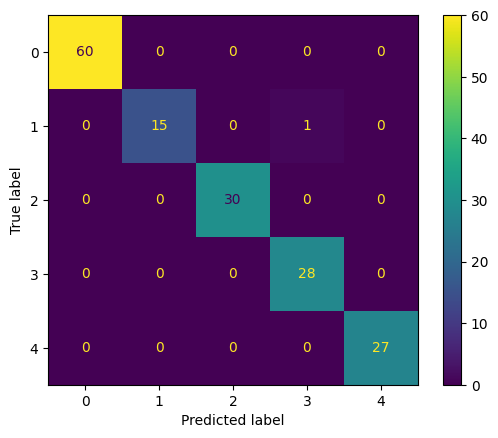

0.9937888198757764

In [10]:
svm = SVC(random_state=10)
baseline_svm_acc = evaluate_classifier(svm, train_data, train_labels, test_data, test_labels, True)
baseline_svm_acc

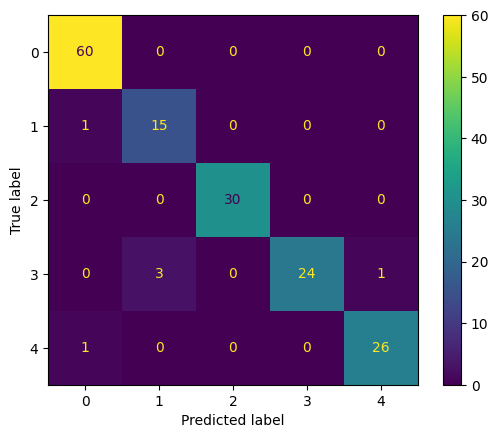

0.9627329192546584

In [11]:
tree = DecisionTreeClassifier(random_state=10)
baseline_tree_acc = evaluate_classifier(tree, train_data, train_labels, test_data, test_labels, True)
baseline_tree_acc

Let's start by scaling the features to an appropriate range. As we can see, our data contains outliers so we will use `RobustScaler` as it usually gives better results when outliers are present in the data.

In [12]:
from sklearn.preprocessing import RobustScaler

first_quartile, third_quartile = np.quantile(train_data, q=[0.25, 0.75], axis=0)
iqr = third_quartile - first_quartile

upper_fence = third_quartile + 1.5 * iqr
lower_fence = first_quartile - 1.5 * iqr

print('Does our data contain any outliers?')
print(np.any([np.any(train_data <= lower_fence, axis=0), np.any(train_data >= upper_fence, axis=0)]))

scaler = RobustScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

Does our data contain any outliers?
True


Let us now retrain the classifiers using the rescaled data. As we can see, our accuracy improved from 0.993789 to 1.0 in case of LogReg, it decreased from 0.992789 to 0.981367 for SVMs and it stayed the same in case of DT. The same accuracy makes sense in case of DT as Decision Trees are invariant to feature scaling.

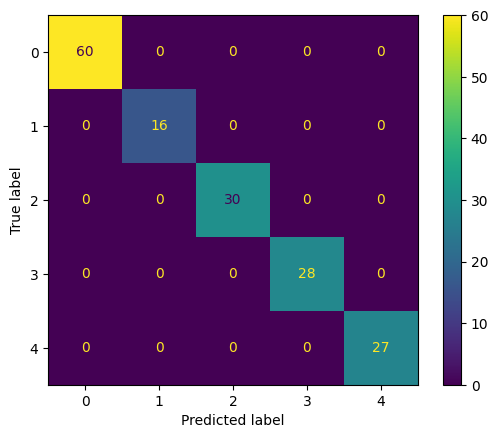

1.0


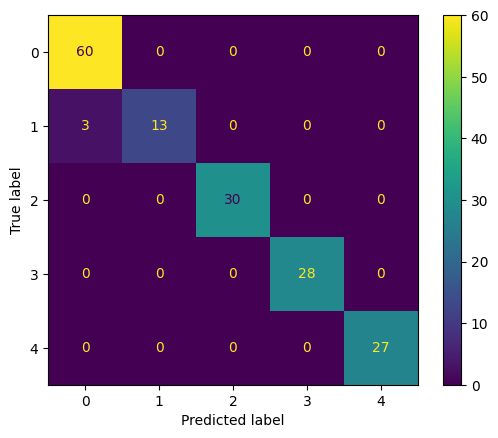

0.9813664596273292


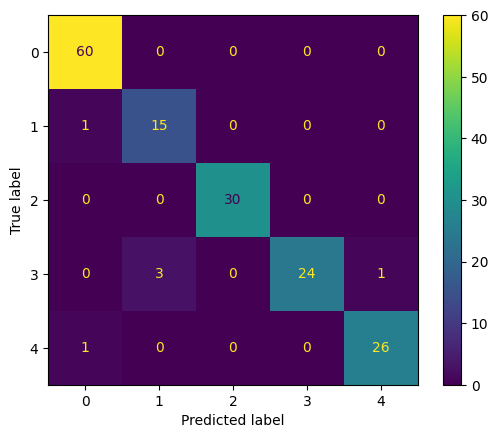

0.9627329192546584


In [13]:
logreg = SGDClassifier('log_loss', n_jobs=-1, random_state=10)
scaled_logreg_acc = evaluate_classifier(logreg, train_data, train_labels, test_data, test_labels, True)
print(scaled_logreg_acc)

svm = SVC(random_state=10)
scaled_svm_acc = evaluate_classifier(svm, train_data, train_labels, test_data, test_labels, True)
print(scaled_svm_acc)

tree = DecisionTreeClassifier(random_state=10)
scaled_tree_acc = evaluate_classifier(tree, train_data, train_labels, test_data, test_labels, True)
print(scaled_tree_acc)

We may noticed that most of the mistakes we make are related to the underrepresented class - Class 1. We will try to improve this by rebalancing the dataset using SMOTE. SMOTE stands for Synthetic Minority Oversampling Technique. It works by finding nearest neighbours from the minority class for each sample $x$ from the same class. Next, it randomly selects one or more nearest neighbours and creates a linear combination of the original sample $x$ and the randomly selected one.

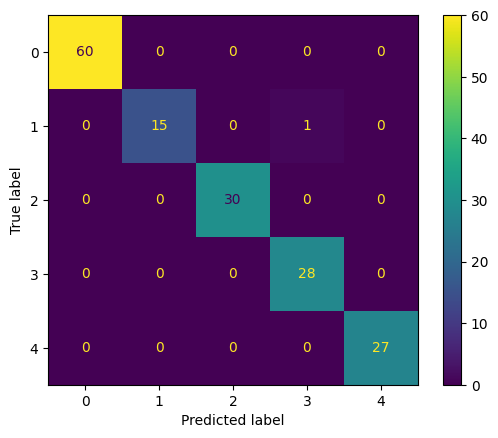

0.9937888198757764


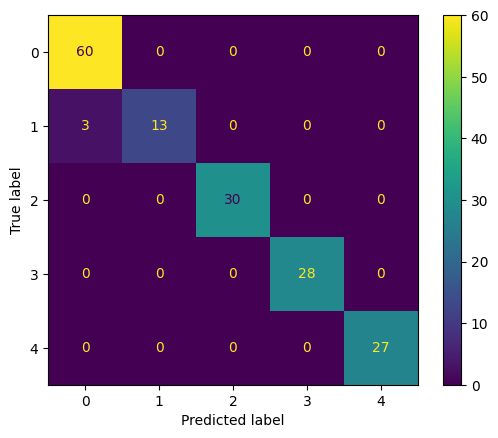

0.9813664596273292


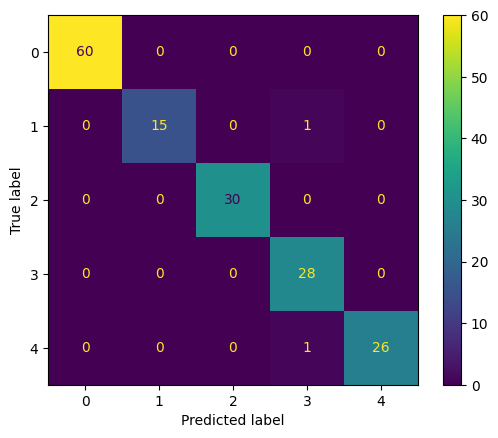

0.9875776397515528


In [14]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(k_neighbors=5, random_state=10)
train_data_resampled, train_labels_resampled = smote.fit_resample(train_data, train_labels)

logreg = SGDClassifier('log_loss', n_jobs=-1, random_state=10)
resampled_logreg_acc = evaluate_classifier(
    logreg, train_data_resampled, train_labels_resampled, test_data, test_labels, True
)
print(resampled_logreg_acc)

svm = SVC(random_state=10)
resampled_svm_acc = evaluate_classifier(
    svm, train_data_resampled, train_labels_resampled, test_data, test_labels, True
)
print(resampled_svm_acc)

tree = DecisionTreeClassifier(random_state=10)
resampled_tree_acc = evaluate_classifier(
    tree, train_data_resampled, train_labels_resampled, test_data, test_labels, True
)
print(resampled_tree_acc)

Unfortunately, SMOTE improved the peformance only in the case of Decision Trees, it did not help in the case of SVMs and it decreased the performance in the case of LogReg. We will not use it in the next stages, instead we will try to decrease the dimensionality of the data by doing feature selection using Random Forests.

In [15]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

feature_selector = SelectFromModel(RandomForestClassifier(random_state=10))
train_data_subsampled = feature_selector.fit_transform(train_data, train_labels)
test_data_subsampled = feature_selector.transform(test_data)

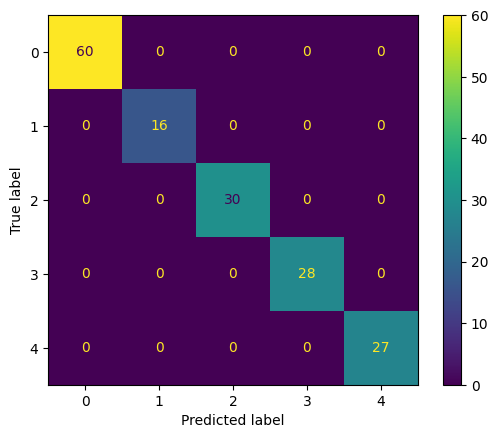

1.0


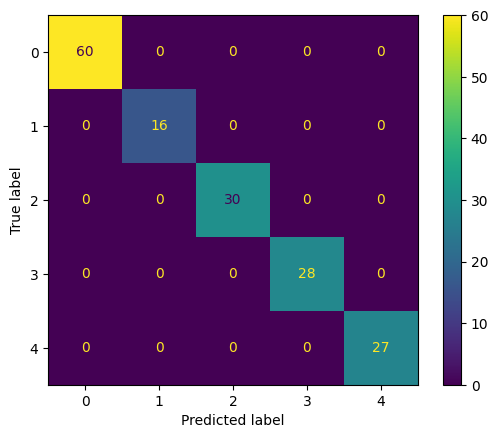

1.0


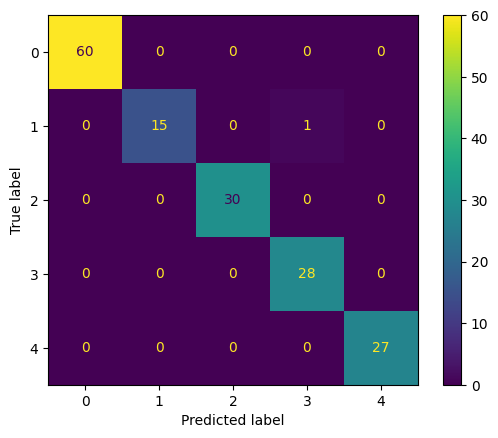

0.9937888198757764


In [16]:
logreg = SGDClassifier('log_loss', n_jobs=-1, random_state=10)
subsampled_logreg_acc = evaluate_classifier(
    logreg, train_data_subsampled, train_labels, test_data_subsampled, test_labels, True
)
print(subsampled_logreg_acc)

svm = SVC(random_state=10)
subsampled_svm_acc = evaluate_classifier(
    svm, train_data_subsampled, train_labels, test_data_subsampled, test_labels, True
)
print(subsampled_svm_acc)

tree = DecisionTreeClassifier(random_state=10)
subsampled_tree_acc = evaluate_classifier(
    tree, train_data_subsampled, train_labels, test_data_subsampled, test_labels, True
)
print(subsampled_tree_acc)

Finally, the feature selection helped and we were able to achieve the perfect accuracy with LogReg and SVMs and we only did one misclassification with Decision Trees. Let's review the results once more.

In [17]:
results = [
    [baseline_logreg_acc, baseline_svm_acc, baseline_tree_acc],
    [scaled_logreg_acc, scaled_svm_acc, baseline_tree_acc],
    [resampled_logreg_acc, resampled_svm_acc, resampled_tree_acc],
    [subsampled_logreg_acc, subsampled_svm_acc, subsampled_tree_acc]
]

pd.DataFrame(
    results, index=['Baseline', 'Rescaled', 'Oversampled', 'Feature Engineering'],
    columns=['Logistic Regression', 'SVM', 'Decision Trees']
)

,Logistic Regression,SVM,Decision Trees
Baseline,0.993789,0.993789,0.962733
Rescaled,1.000000,0.981366,0.962733
Oversampled,0.993789,0.981366,0.987578
Feature Engineering,1.000000,1.000000,0.993789
